In [55]:
#data stuff
import time
import pandas as pd
import numpy as np
import datetime as dt

#regression stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#graph stuff
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'


#import functions from other file that we want
from utilities import *

--------------

--------------

--------------

--------------

# PART I: Cookieless (Viewthrough) Multipliers EDA

# 0.1 Read in PMD Data

Note: When running back to 2016 or so this costs 90GB, running back through beginning of 2020 costs about 25GB

In [2]:
q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2019-01-01' and attr_window in('Media Reported - Click Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

start_time = time.time() 

clickthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

time took: 157.67


In [5]:
q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2019-01-01' and attr_window in('Media Reported - View Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

start_time = time.time() 

viewthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

time took: 161.04


In [14]:
#rename columns in the separate dataframes to identify clickthru and viewthru
#first clickthru
for col in clickthru_df.columns:
    if 'conversions' in col: 
        clickthru_df[col+'_ct'] = clickthru_df[col]
        clickthru_df.drop(col, axis=1, inplace=True)
        
#now viewthru
for col in viewthru_df.columns:
    if 'conversions' in col: 
        viewthru_df[col+'_vt'] = viewthru_df[col]
        viewthru_df.drop(col, axis=1, inplace=True)
        
        

In [22]:
#now merge the dataframes 
#create a truncated version of viewthru DF to make the merge more efficient
vt_merge = viewthru_df[['account','campaign','_match','date','marketing_segment'] + [col for col in viewthru_df.columns if 'conversions' in col]]

#merge with clickthru df
df = clickthru_df.merge(vt_merge, how='left', on=[col for col in vt_merge.columns if 'conversions' not in col])

# 0.2 Basic Data Cleaning

#### Clean the Data

In [23]:
df['marketing_subinitiative'].value_counts()

Core                          617194
Games                          78855
X-UNKNOWN-X                    56184
Cooking                        54458
Home Delivery                  46719
EDU                            28179
Games (former: Crosswords)      3733
Cooking Gift                     943
Audio                            898
Games Gift                       881
Sway                             569
Name: marketing_subinitiative, dtype: int64

In [24]:
#some Twigeo campaigns don't get recognized as Games campaigns in PMD, manually correct those
df.loc[(df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (df['campaign'].str.contains('game')) | 
          (df['campaign'].str.contains('xwd')) | 
          (df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

#### add columns for easier grouping (quarter, month, week) + analysis

In [25]:
#create date-based aggregation columns for easier grouping
df['year_month_cal'] = df['date'].dt.to_period('M').apply(lambda r: r.start_time)
df['year_week_monday'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df['year_quarter'] = df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [26]:
#create a composite channel-marketing-initiative column for easier grouping
df['channel_mkt_init'] = df['channel'] + " - " + df['marketing_initiative']

__NOTE: we are going to remove brand, app install, retention data because it is not acquisition-focused__

In [28]:
df['marketing_initiative'].value_counts()

Business As Usual               343994
Sale                            233733
Content/Audience Development    198565
X-UNKNOWN-X                      48160
One Day Sale                     16930
App Download                     13609
App-Install                      11240
Branding                          9658
Brand                             5674
Gifting                           4332
Testing                           1224
Engagement                        1144
Thanksgiving Cooking               104
Retention                          104
December Holiday Cooking           104
Audience Content                    22
Non-Specific                        16
Name: marketing_initiative, dtype: int64

In [77]:
df = df[~df['marketing_initiative'].isin(['Brand','Branding','Retention','App Download', 'App-Install'])]

In [78]:
df.shape

(848328, 32)

<AxesSubplot:xlabel='date'>

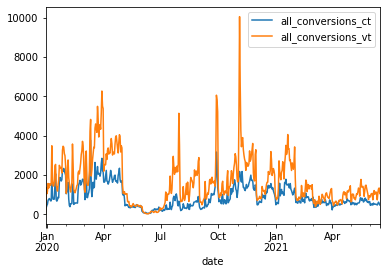

In [79]:
df.groupby('date')[['all_conversions_ct','all_conversions_vt']].sum().plot()

Note: when we group all data at the daily level, there is a strong relationship between spend, impressions, clickthrough conversions and the variable we care about: viewthrough conversions. This is a good indication that we can come up with a multiplier or model-based approach using some of this data. 

In [80]:
df.groupby('date')[['spend','impressions','all_conversions_ct','all_conversions_vt']].sum().corr()

spend  impressions  all_conversions_ct  \
spend               1.000000     0.879415            0.769344   
impressions         0.879415     1.000000            0.739251   
all_conversions_ct  0.769344     0.739251            1.000000   
all_conversions_vt  0.726609     0.757588            0.867618   

                    all_conversions_vt  
spend                         0.726609  
impressions                   0.757588  
all_conversions_ct            0.867618  
all_conversions_vt            1.000000

------------------

------------------

------------------

------------------

------------------

I decided to mess around and try a regression model with this data. Results look promising - there's definitely room to improve this model by getting creative with the inputs. 

This data is also currently grouped at the daily level. Each day just has one count of impressions, spend, and clickthrough conversions. For this analysis to be a bit more usable we'll need to explore ways we can split up this data by publisher and see if we can get a read for individual channels (e.g. Google, Twitter, FB, etc...)

## _Try a Model_

In [81]:
test = df.groupby('date')[['impressions','clicks','all_conversions_ct','all_conversions_vt']].sum()

In [82]:
indep_vars = [col for col in test.columns if '_vt' not in col]

In [83]:
X = test[indep_vars]
y = test[['all_conversions_vt']]

In [84]:
# scaler = StandardScaler()
# scaled = scaler.fit_transform(X)

# X = pd.DataFrame(data=scaled, columns=X.columns)
# X['date'] = test.index.values
# X.set_index('date', inplace=True)

# y['date'] = test.index.values
# y.set_index('date', inplace=True)

In [85]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     857.6
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          2.73e-203
Time:                        10:53:58   Log-Likelihood:                -4105.2
No. Observations:                 536   AIC:                             8218.
Df Residuals:                     532   BIC:                             8236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -123.7693     42.390     -2.920      0.004    -207.041     -40.498
impressions         3.087e-05   2.06e-06     15.010      0.000    2.68e-05    3.49e-05
clicks                -0.0026      0.000    -11.966      0.000      -0.003      -0.002
all_conversions_ct     1.4049      0.055     25.448      0.000       1.296       1.513
==============================================================================
Omnibus:                      506.774   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32992.036
Skew:                           3.879   Prob(JB):                         0.00
Kurtosis:                      40.644   Cond. No.                     7.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y
ol_vis['resid'] = ols_vis['y_pred'] - ols_vis['y_actual']

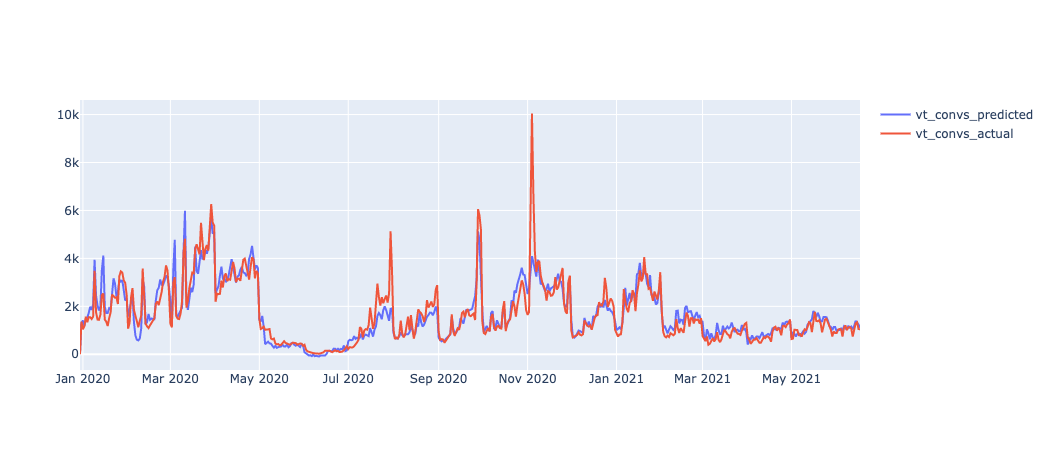

In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='vt_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='vt_convs_actual'))

fig.show()

__Try holding out the last few months__

In [92]:
is_s = '2019-01-01'
is_e = '2021-03-31'

oos_s = '2021-04-01'
oos_e = '2021-06-15'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [93]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     693.3
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          4.79e-169
Time:                        11:17:20   Log-Likelihood:                -3539.5
No. Observations:                 458   AIC:                             7087.
Df Residuals:                     454   BIC:                             7103.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -95.5185     49.448     -1.932      0.054    -192.694       1.657
impressions         3.093e-05   2.25e-06     13.731      0.000    2.65e-05    3.54e-05
clicks                -0.0026      0.000    -11.142      0.000      -0.003      -0.002
all_conversions_ct     1.3914      0.060     23.092      0.000       1.273       1.510
==============================================================================
Omnibus:                      417.361   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21733.316
Skew:                           3.649   Prob(JB):                         0.00
Kurtosis:                      35.948   Cond. No.                     7.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train
train_ols_vis['resid'] = train_ols_vis['y_pred'] - train_ols_vis['y_actual']

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test
test_ols_vis['resid'] = test_ols_vis['y_pred'] - test_ols_vis['y_actual']

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

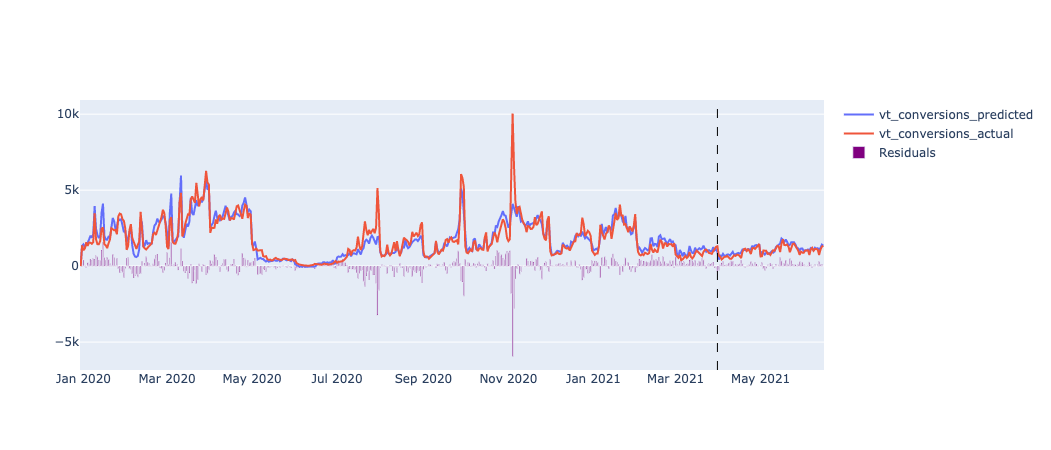

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='vt_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='vt_conversions_actual'))
fig.add_trace(go.Bar(
    x=ols_vis.index,
    y=ols_vis['resid'],
    name='Residuals',
    marker_color='purple'
))

fig.add_vline(x='2021-03-31', line_width=1, line_dash="dash", line_color="black")

fig.show()

# __APPENDIX__

### Create a DF of Core-Only campaigns

In [ ]:
df['marketing_subinitiative'].value_counts()

In [ ]:
#limit to Core campaigns 
df_core = df[df['marketing_subinitiative'].isin(['Core','CORE Business', 'Home Delivery','EDU'])]

#remove mobile partners - conversion data is unreliable in PMD
df_core = df_core[~(df_core['account'].str.contains('Twigeo')) & 
                 ~(df_core['account'] == 'The New York Times App')]

#remove app install and app-based campaigns so we focus only on web
df_core['campaign'] = df_core['campaign'].str.lower()
df_core = df_core[~df_core['campaign'].str.contains('app')]


#limit attribution window to media-reported. We may want to reexamine this analysis in the future using other windows
#such as 7d-all or 1d-all
df_core = df_core[df_core['attr_window'] == 'Combined']

In [ ]:
df_core.shape

__create a daily core dataframe__

In [ ]:
#create daily view of impressions, core starts, spg starts
df_core_daily = df_core.groupby(['year_quarter','year_month_cal','year_week_monday','date'])['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum().reset_index()

#rename cols
df_core_daily.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                                'clicks':'core_clicks', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

### Create a DF of SPG-Only Campaigns

In [ ]:
df_spg = df[(df['marketing_subinitiative'].isin(['Cooking','Games'])) & 
  ~(df['campaign'].str.contains('app'))]

In [ ]:
df_spg.shape

In [ ]:
df_spg[['ck_conversions','games_conversions']].sum()

__create a daily SPG dataframe__

In [ ]:
df_spg_daily = df_spg.groupby(['year_quarter','year_month_cal','year_week_monday',
                               'date', 'marketing_subinitiative'])['spend','impressions','spg_conversions'].sum().reset_index()

df_spg_daily = df_spg_daily.pivot(index=['year_quarter','year_month_cal','year_week_monday','date'], 
                                  columns='marketing_subinitiative', 
                                  values=['spend','impressions', 'spg_conversions']).reset_index()

df_spg_daily.columns = ['_'.join(col).strip() for col in df_spg_daily.columns.values]
df_spg_daily.rename(columns = {'spend_Cooking':'ck_spend',
                               'spend_Games':'games_spend',
                               'impressions_Cooking':'ck_impressions',
                               'impressions_Games':'games_impressions',
                               'spg_conversions_Cooking':'ck_ck_conversions',
                               'spg_conversions_Games':'games_games_conversions',
                               'year_quarter_':'year_quarter',
                               'year_month_cal_':'year_month_cal',
                               'year_week_monday_':'year_week_monday',
                               'date_':'date'
                              },
                   inplace=True)

df_spg_daily['spg_spend'] = df_spg_daily['ck_spend'] + df_spg_daily['games_spend']
df_spg_daily['spg_impressions'] = df_spg_daily['ck_impressions'] + df_spg_daily['games_impressions']
df_spg_daily['spg_spg_conversions'] = df_spg_daily['ck_ck_conversions'] + df_spg_daily['games_games_conversions']

#### Combine Core and SPG DFs to get one daily view

In [ ]:
df_daily = df_core_daily.merge(df_spg_daily, how='left', on=['year_quarter','year_month_cal','year_week_monday','date'])
df_daily['date'] = df_daily.astype('datetime64[ns]')

In [ ]:
df_daily.head()

# 1.1 Top level analysis on Core-to-SPG cross sell (Core campaigns driving CK or Games starts)

In [ ]:
#understand overall impact 1 Jan 2019 - 1 May 2021
df_core[['core_conversions','games_conversions','ck_conversions']].sum()

__Since January 2019, web-based Core media (note: this analysis excludes app-based media) has generated 1.66M starts. It has also recorded 32.9k Games starts and 59.7k Cooking starts which have never been recognized!__

The most recent 5 year LTVs I found for Cooking and Games are as follows: 
* Cooking: $124

* Games: $97

In [ ]:
start_sums = df_core[['core_conversions','games_conversions','ck_conversions']].sum().to_frame()
games_val = start_sums.loc['games_conversions'][0] * 97
ck_val = start_sums.loc['ck_conversions'][0] * 124

In [ ]:
print('Games added value: ${:>15,.2f}'.format(games_val))
print('CK added value: ${:>18,.2f}'.format(ck_val))
print('Combined value: ${:>18,.2f}'.format(games_val + ck_val, 2))

This means upon initial glance, web-based campaigns since Jan 2019 have generated over $10.6M in unrecognized value based on media reporting. 

However, this is an incomplete picture because we don't know: 
<ol>
    <li> to what extent the core campaigns actually drove these conversions (are they incremental?) </li>
    <li> if these starts were already counted as part of separate CK or Games campaigns (are they deduplicated?) </li>
</ol>

## Create Quarterly, Monthly, Weekly, Daily views of impressions, core starts, SPG starts to understand if there is a consistent relationship

In [ ]:
#get lists of columns for product-specific analysis
core_to_ck_cols = [col for col in df_daily.columns if ('core' in col and 'games' not in col and 'spg' not in col) or 'ck' in col]
core_to_games_cols = [col for col in df_daily.columns if ('core' in col and 'ck' not in col and 'spg' not in col) or 'games' in col]
core_to_spg_cols = [col for col in df_daily.columns if ('core' in col and 'games' not in col and 'ck' not in col) or 'spg' in col]


### Quarterly, Monthly, Weekly

In [ ]:
#group by quarter, month, week
df_qtr = df_daily.groupby('year_quarter').sum()
df_monthly = df_daily.groupby('year_month_cal').sum()
df_weekly = df_daily.groupby('year_week_monday').sum()

In [ ]:
get_corr_matrix(df_weekly, core_to_games_cols, start='2019-01-01', end='2020-03-30')

In [ ]:
plot_variables(df_weekly, ['games_impressions','games_games_conversions', 'games_spend'], one_plot=True, scaled=True)

In [ ]:
plot_variables(df_weekly['2020-04-01':], core_to_games_cols, one_plot=True, scaled=True)

In [ ]:
df_weekly.corrwith(df_weekly['core_spg_conversions']).sort_values(ascending=False)

In [ ]:
fig = make_subplots(rows=5, cols=2, 
                   subplot_titles = [item + f": {round(df_core_qtr.corrwith(df_core_qtr['core_spg_conversions']).sort_values(ascending=False)[item], 2)}" for item in df_core_qtr.corrwith(df_core_qtr['core_spg_conversions']).sort_values(ascending=False).index])

i = 0
row_list = [1,1,2,2,3,3,4,4,5,5]
x = df_core_qtr['core_spg_conversions']

for col in df_core_qtr.corrwith(df_core_qtr['core_spg_conversions']).sort_values(ascending=False).index:
    
    fig.add_trace(
        go.Scatter(
            x=x,
            y=df_core_qtr[col],
            mode='markers'
        ),
        row=row_list[i], col= (i%2) + 1
    )
    
    i += 1

fig.update_layout(height=2000, width=800, title_text="Core-driven SPG starts scatterplots", showlegend=False)

fig.show()

### Monthly

In [ ]:
#create monthly view of impressions, core starts, spg starts
df_core_mnth = df_core.groupby('year_month_cal')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_mnth.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions',
                               'clicks':'core_clicks',
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_mnth = df_spg.groupby('year_month_cal')['spend','impressions','spg_conversions'].sum()
df_spg_mnth.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_mnth = df_core_mnth.merge(df_spg_mnth, left_index=True, right_index=True)

In [ ]:
get_corr_matrix(df_core_mnth, var_list=df_core_mnth.columns, start=df_core_mnth.index.min(), end=df_core_mnth.index.max())

In [ ]:
plot_variables(df_core_mnth, df_core_mnth.columns, one_plot=True, scaled=True)

In [ ]:
fig = make_subplots(rows=5, cols=2, 
                   subplot_titles = [item + f": {round(df_core_mnth.corrwith(df_core_mnth['core_spg_conversions']).sort_values(ascending=False)[item], 2)}" for item in df_core_mnth.corrwith(df_core_mnth['core_spg_conversions']).sort_values(ascending=False).index])

i = 0
row_list = [1,1,2,2,3,3,4,4,5,5]
x = df_core_mnth['core_spg_conversions']

for col in df_core_mnth.corrwith(df_core_mnth['core_spg_conversions']).sort_values(ascending=False).index:
    
    fig.add_trace(
        go.Scatter(
            x=x,
            y=df_core_mnth[col],
            mode='markers'
        ),
        row=row_list[i], col= (i%2) + 1
    )
    
    i += 1

fig.update_layout(height=2000, width=800, title_text="Core-driven SPG starts scatterplots", showlegend=False)

fig.show()

### Weekly

In [ ]:
#create monthly view of impressions, core starts, spg starts
df_core_wk = df_core.groupby('year_week_monday')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_wk.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions',
                             'clicks':'core_clicks',
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_wk = df_spg.groupby('year_week_monday')['spend','impressions','spg_conversions'].sum()
df_spg_wk.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_wk = df_core_wk.merge(df_spg_wk, left_index=True, right_index=True)

In [ ]:
get_corr_matrix(df_core_wk, var_list=df_core_wk.columns, start=df_core_wk.index.min(), end=df_core_wk.index.max())

In [ ]:
plot_variables(df_core_wk, df_core_wk.columns, one_plot=True, scaled=True)

In [ ]:
fig = make_subplots(rows=5, cols=2, 
                   subplot_titles = [item + f": {round(df_core_wk.corrwith(df_core_wk['core_spg_conversions']).sort_values(ascending=False)[item], 2)}" for item in df_core_wk.corrwith(df_core_wk['core_spg_conversions']).sort_values(ascending=False).index])

i = 0
row_list = [1,1,2,2,3,3,4,4,5,5]
x = df_core_wk['core_spg_conversions']

for col in df_core_wk.corrwith(df_core_wk['core_spg_conversions']).sort_values(ascending=False).index:
    
    fig.add_trace(
        go.Scatter(
            x=x,
            y=df_core_wk[col],
            mode='markers'
        ),
        row=row_list[i], col= (i%2) + 1
    )
    
    i += 1

fig.update_layout(height=2000, width=800, title_text="Core-driven SPG starts scatterplots", showlegend=False)

fig.show()

### Daily

In [ ]:
#create monthly view of impressions, core starts, spg starts
df_core_daily = df_core.groupby('date')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_daily.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                                'clicks':'core_clicks', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_daily = df_spg.groupby('date')['spend','impressions','spg_conversions'].sum()
df_spg_daily.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_daily = df_core_daily.merge(df_spg_daily, left_index=True, right_index=True)

In [ ]:
get_corr_matrix(df_core_daily, var_list=df_core_daily.columns, start=df_core_daily.index.min(), end=df_core_daily.index.max())

In [ ]:
plot_variables(df_core_daily, df_core_daily.columns, one_plot=True, scaled=True)

In [ ]:
fig = make_subplots(rows=5, cols=2, 
                   subplot_titles = [item + f": {round(df_core_daily.corrwith(df_core_daily['core_spg_conversions']).sort_values(ascending=False)[item], 2)}" for item in df_core_daily.corrwith(df_core_daily['core_spg_conversions']).sort_values(ascending=False).index])

i = 0
row_list = [1,1,2,2,3,3,4,4,5,5]
x = df_core_daily['core_spg_conversions']

for col in df_core_daily.corrwith(df_core_daily['core_spg_conversions']).sort_values(ascending=False).index:
    
    fig.add_trace(
        go.Scatter(
            x=x,
            y=df_core_daily[col],
            mode='markers'
        ),
        row=row_list[i], col= (i%2) + 1
    )
    
    i += 1

fig.update_layout(height=2000, width=800, title_text="Core-driven SPG starts scatterplots", showlegend=False)

fig.show()

# 2. look for more granular correlations

In [ ]:
correls_df = df_core.groupby(['year_month_cal','year_week_monday','date','channel_mkt_init']).sum().reset_index()
correls_df = correls_df.pivot(index='date', columns='channel_mkt_init', values=['clicks','impressions','games_conversions','ck_conversions', 'spg_conversions'])

correls_df.columns = ['_'.join(col).strip() for col in correls_df.columns.values]

In [ ]:
correls_df.columns = correls_df.columns.str.replace(' - ','_').str.replace('/','').str.replace(' ', '')

In [ ]:
df_core['channel'].unique()

In [ ]:
correls_df[[col for col in correls_df.columns if 'Native' in col and 'ck_conversions' not in col and 'games_conversions' not in col]].corr()

In [ ]:
plot_variables(correls_df, ['clicks_Native_Sale','impressions_Native_Sale','spg_conversions_Native_Sale'], one_plot=True, scaled=True)

# 2 Try regression - with all data and impression volumes across channel_mkt_init

__construct impressions, clicks, and starts columns__

In [ ]:
reg_df = df_core.groupby(['date','channel_mkt_init'])['clicks','impressions','spend','core_conversions','spg_conversions'].sum().reset_index()

In [ ]:
reg_df = reg_df.pivot(index='date', columns='channel_mkt_init', values=['clicks','impressions','spend','core_conversions','spg_conversions'])

In [ ]:
reg_df.columns = reg_df.columns = ['_'.join(col).strip() for col in reg_df.columns.values]

In [ ]:
reg_df.fillna(0, inplace=True)

In [ ]:
reg_df.reset_index(inplace=True)
reg_df['date'] = reg_df['date'].astype('datetime64[ns]')

In [ ]:
reg_df['spg_conversions_all'] = reg_df[[col for col in reg_df.columns if 'spg_conversions' in col]].sum(axis=1)

In [ ]:
#create month and weekday cols for dummies
reg_df['weekday'] = reg_df['date'].apply(lambda x: x.strftime('%A'))
reg_df['month'] = reg_df['date'].dt.month_name()

#create a merge dummies 
reg_df = pd.concat([reg_df, 
               pd.get_dummies(reg_df['weekday'], prefix='weekday'), 
               pd.get_dummies(reg_df['month'], prefix='month')], axis=1)

__add spg impressions, spend information__

In [ ]:
#create reg_dfs from main data pull with only cooking and games data

cooking_reg_df = df[(df['marketing_subinitiative'].isin(['Cooking'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

games_reg_df = df[(df['marketing_subinitiative'].isin(['Games'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

In [ ]:
#clean up date col
cooking_reg_df['date'] = cooking_reg_df['date'].astype('datetime64[ns]')
games_reg_df['date'] = games_reg_df['date'].astype('datetime64[ns]')

In [ ]:
#group cooking and games reg_dfs to daily spend, impressions + rename cols
cooking_daily = cooking_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'ck_impressions',
                                                                                       'spend':'ck_spend'})
games_daily = games_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'games_impressions',
                                                                                       'spend':'games_spend'})

In [ ]:
#merge cooking and games info into reg_df that we'll use for regression
reg_df = reg_df.merge(cooking_daily, how='left', on='date')
reg_df = reg_df.merge(games_daily, how='left', on='date')

In [ ]:
#fill NA with 0
reg_df.fillna(0, inplace=True)

In [ ]:
#set index as date
reg_df.set_index('date', inplace=True)

In [ ]:
indep_vars = [col for col in reg_df.columns if 'impressions' in col and 'Brand' not in col and 'UNKNOWN' not in col] + \
[col for col in reg_df.columns if 'month_' in col]
# [col for col in reg_df.columns if 'weekday_' in col] + \
# [col for col in reg_df.columns if 'core_conversions' in col]

In [ ]:
X = reg_df[indep_vars]
y = reg_df[['spg_conversions_all']]

In [ ]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(X)

# X = pd.DataFrame(data=scaled, columns=X.columns)
# X['date'] = reg_df_reg.index.values
# X.set_index('date', inplace=True)

# y['date'] = reg_df_reg.index.values
# y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_convs_actual'))

fig.show()

__Try holding out the last few months__

In [ ]:
is_s = '2019-01-01'
is_e = '2020-09-30'

oos_s = '2020-10-01'
oos_e = '2020-12-01'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [ ]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

In [ ]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_conversions_actual'))

fig.show()

In [ ]:
test = reg_df[indep_vars + ['spg_conversions_all']].loc[oos_s:oos_e]
test = sm.add_constant(test)
indep_vars = indep_vars + ['const']

In [ ]:
test.head()

In [ ]:
utilities.oos_testing(test,ols,indep_vars,oos_s,oos_e,is_s,is_e,dep='spg_conversions_all')

In [ ]:
ols_vis['all_core_impressions'] = ols_vis[[col for col in ols_vis.columns if 'impressions' in col and 'games' not in col and 'ck_' not in col]].sum(axis=1)

In [ ]:
plot_variables(ols_vis, ['games_impressions','ck_impressions','all_impressions','y_pred','y_actual'], one_plot=True, scaled=True)

__Try Stepwise__

In [ ]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    i = 1
    while remaining and current_score == best_new_score:
        print(f"Iteration: {i}")
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("New best model found")
            print(formula)
        i += 1
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
stepwise_df = reg_df[is_s:is_e][indep_vars + ['spg_conversions_all']]

In [ ]:
stepwise_df.head()

In [ ]:
stepwise_df.columns = stepwise_df.columns.str.replace(' ', '')
stepwise_df.columns = stepwise_df.columns.str.replace('-','_')
stepwise_df.columns = stepwise_df.columns.str.replace('/','_')

In [ ]:
formula = "spg_conversions_all ~ ck_impressions + games_impressions + impressions_Display_Sale + impressions_Social_BusinessAsUsual + impressions_PaidSearch_Sale + month_June + month_April + impressions_PaidSearch_Gifting + impressions_Display_Gifting + month_May + impressions_Native_Content_AudienceDevelopment + impressions_Social_Gifting + impressions_Social_Content_AudienceDevelopment + impressions_PaidSearch_BusinessAsUsual + impressions_Display_Testing + month_March + month_July + impressions_Social_X_UNKNOWN_X + impressions_Display_BusinessAsUsual + impressions_Display_Content_AudienceDevelopment + 1"
stepwise_model = smf.ols(formula, stepwise_df).fit()

In [ ]:
stepwise_model.summary()

In [ ]:
stepwise_df_test = reg_df[oos_s:oos_e][indep_vars]

stepwise_df_test.columns = stepwise_df_test.columns.str.replace(' ', '')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('-','_')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('/','_')

stepwise_df_train = reg_df[is_s:is_e][indep_vars]

stepwise_df_train.columns = stepwise_df_train.columns.str.replace(' ', '')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('-','_')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('/','_')

In [ ]:
#####################################
# TRAIN
######################################

stepwise_train_y_pred = stepwise_model.predict(stepwise_df_train)
stepwise_df_train['y_pred'] = stepwise_train_y_pred
stepwise_df_train['y_actual'] = reg_df[is_s:is_e]['spg_conversions_all']

#####################################
# TEST
######################################
stepwise_test_y_pred = stepwise_model.predict(stepwise_df_test)
stepwise_df_test['y_pred'] = stepwise_test_y_pred
stepwise_df_test['y_actual'] = reg_df[oos_s:oos_e]['spg_conversions_all']

######################################
# COMBINE
######################################

stepwise_vis = pd.concat([stepwise_df_train,stepwise_df_test])

In [ ]:
plot_variables(stepwise_vis, ['y_pred','y_actual'], one_plot=True, scaled=False)

# 3. Capture basic info on cross-sell (Cooking Only)

# 3.1 Identify cross-sell patterns (CK)

__Look at volumes__

In [ ]:
mkt_init_vol = df_core.groupby(['marketing_initiative'])['impressions', 'ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
mkt_init_vol.reset_index(inplace=True)
mkt_init_vol['impression_weights'] = mkt_init_vol['impressions'] / mkt_init_vol['ck_conversions']
mkt_init_vol

In [ ]:
mkt_init_vol.sort_values('impression_weights', ascending=True)

Sale, Content/Audience Dev, and BAU make up the vast majority of CK cross sells. However, this is mostly because of sheer impression volume. The most efficient tactics are those with the lowest impression weights - Testing, Gifting, Audience Content, Content/Audience Dev.

In [ ]:
channel_vol = df_core.groupby(['channel'])['impressions','ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
channel_vol.reset_index(inplace=True)
channel_vol['impression_weights'] = channel_vol['impressions'] / channel_vol['ck_conversions']
channel_vol

In [ ]:
channel_vol.sort_values('impression_weights', ascending=True).head(5)

Display, Native and Social drove the most cross-sells. But Paid Search drove the most efficient cross-sells.

In [ ]:
channel_mkt_vol = df_core.groupby('channel_mkt_init')['impressions','ck_conversions'].sum().sort_values('ck_conversions',ascending=False)
channel_mkt_vol.reset_index(inplace=True)
channel_mkt_vol['impression_weights'] = channel_mkt_vol['impressions'] / channel_mkt_vol['ck_conversions']
channel_mkt_vol.head(10)

In [ ]:
channel_mkt_vol.sort_values('impression_weights', ascending=True).head(10)

Various Paid Search and Display tactics drove the most efficient cross-sell results. Meanwhile, Display Social and Native (Sale and Content/Audience Dev) drove the highest volume of cross-sells.

__Look at correlations__

In [ ]:
#create monthly view
df_core_monthly = df_core.groupby(['year_month_cal','channel_mkt_init'])[['clicks','impressions','games_conversions','ck_conversions']].sum().reset_index()

#pivot to only have only one row per month
df_core_monthly = df_core_monthly.pivot(index='year_month_cal', columns='channel_mkt_init', values=['clicks','impressions','games_conversions','ck_conversions'])

In [ ]:
#flatten index
df_core_monthly.columns = df_core_monthly.columns.to_flat_index()

In [ ]:
#create one aggregate ck starts column for simpler correlations
df_core_monthly['ck_conversions_all'] = df_core_monthly[[col for col in df_core_monthly.columns if 'ck_conversions' in col]].sum(axis=1)

In [ ]:
#start with just impressions and ck conversions
ck_imps_monthly = df_core_monthly[[col for col in df_core_monthly.columns if 'impressions' in col] + ['ck_conversions_all']]

In [ ]:
#replace nans with 0 because it means there were no impressions in that period
ck_imps_monthly.fillna(0, inplace=True)

In [ ]:
#get correlations between ck starts and impression volumes
ck_convs_imps_corr = ck_imps_monthly.corrwith(ck_imps_monthly['ck_conversions_all']).to_frame().rename(columns={0:'corr_with_ck_conv'}).reset_index()

#sort the frame
ck_convs_imps_corr.sort_values('corr_with_ck_conv', ascending=False, inplace=True)

In [ ]:
ck_convs_imps_corr.head(20)

Based on the above correlation chart, it seems that __sales__ have the strongest relationship with cross-sell starts. Major channels such as Paid Search, Display, Native, and Social show the highest correlation. That said, the highest correlation by far is Paid Search - Sale; other channels have modest relationships with CK conversions (~.50 or less)

This preliminary analysis would indicate that sale-based Core media does the best job attracting Cooking starts.

Social - Audience/Content also seems to do a fairly good job generating CK starts.

In [ ]:
ck_imps_monthly.shape

__Does a relationship exist?__

Check to see if any of the correlations meet this threshold: 

\begin{align}
\left | r \right | \geq  \frac{2}{\sqrt{n}}
\end{align}

In [ ]:
ck_convs_imps_corr['rel_threshold'] = 2 / np.sqrt(29)

In [ ]:
ck_convs_imps_corr

# 3.2 Try a Regression (CK)

cols to try: 
* campaign_objective
* marketing_initiative
* marketing_segment
* channel
* platform
* impressions
* core_conversions
* month dummy

In [ ]:
#reduce number of cols 
df_reg = df_core[(df_core['channel'].isin(['Display','Native','Social','Paid Search'])) & 
                (df_core['marketing_initiative'].isin(['Sale','Content/Audience Development','Business As Usual','One Day Sale']))].groupby(['date','channel','marketing_initiative'])[['impressions','core_conversions','ck_conversions']].sum().reset_index()

In [ ]:
df_reg.groupby(['date'])[['impressions','core_conversions','ck_conversions']].sum().corr()

In [ ]:
#create month and weekday cols for dummies
df_reg['weekday'] = df_reg['date'].apply(lambda x: x.strftime('%A'))
df_reg['month'] = df_reg['date'].dt.month_name()

#create a merge dummies 
df_reg = pd.concat([df_reg, 
                  pd.get_dummies(df_reg['channel'], prefix='channel'),
                 pd.get_dummies(df_reg['marketing_initiative'], prefix='mkt_init'), 
               pd.get_dummies(df_reg['weekday'], prefix='weekday'), 
               pd.get_dummies(df_reg['month'], prefix='month')], axis=1)

#drop old cols and set index to date
df_reg.drop(['channel','marketing_initiative','weekday','month'], axis=1, inplace=True)
df_reg.set_index('date', inplace=True)

# #add some holiday dummies for cooking 
# df_reg['xmas'] = 0
# df_reg.loc['2020-12-20':'2020-12-25', 'xmas'] = 1

# df_reg['thanksgiving'] = 0
# df_reg.loc['2020-11-22':'2020-11-25', 'thanksgiving'] = 1


In [ ]:
df_reg = df_reg.groupby('date').agg({'impressions': 'sum',
                            'core_conversions':'sum',
                            'ck_conversions':'sum',
                            'channel_Display':'max',
                             'channel_Native':'max',
                             'channel_Paid Search':'max',
                             'channel_Social':'max',
                             'mkt_init_Business As Usual':'max',
                             'mkt_init_Content/Audience Development':'max',
                             'mkt_init_One Day Sale':'max',
                             'mkt_init_Sale':'max',
                             'month_April':'max',
                             'month_August':'max',
                             'month_December':'max',
                             'month_February':'max',
                             'month_January':'max',
                             'month_July':'max',
                             'month_June':'max',
                             'month_March':'max',
                             'month_May':'max',
                             'month_November':'max',
                             'month_October':'max',
                             'month_September':'max',
                             'weekday_Friday':'max',
                             'weekday_Monday':'max',
                             'weekday_Saturday':'max',
                             'weekday_Sunday':'max',
                             'weekday_Thursday':'max',
                             'weekday_Tuesday':'max',
                             'weekday_Wednesday':'max'})

In [ ]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

ols_daily = ols_vis.reset_index().groupby('date').sum()


fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

__Scaled version of residuals plot__

In [ ]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

The initial pass was garbage. There are likely several reasons for this, but first and foremost is that we have too many independent variables, too few observations which include those independent variables, and independent variables that have little to no relationship with our dependent (in this case, Cooking starts). 

To refine the regression approach we need to do more EDA to understand which channels and tactics have the most explanatory power.

__NOTE: CK conversions drop to near zero in May through July, and also have major spikes around Thanksgiving and Xmas. Cooking media went dark in May through July, and also has the heaviest spend around the aforementioned holidays. The absence of Cooking starts during the dark period and the holiday spikes could indicate that these Cooking "cross sell" starts are really being driven by Cooking media, and the audiences also happened to be served Core ads which greedily picked up the credit. Need to explore this further - very important caveat to this analysis__

__Critical open question:__
* How do we remove the influence of Cooking/Games paid media that ran concurrently with Core paid media?

One possible solution could be to __only include click-through cross-sell conversions__ in this analysis. That way we can be a little more sure that it was, in fact, the Core ad that generated the CK or Games conversion. This would be a more conservative approach, but would mitigate the risk that we go on to calculate a blended CPO based on misattributed viewthrough conversions.

### Try two model improvements, separately: 

#### A) just look at click-thru conversions
#### B) add in CK spend/impressions to regression and see how it correlates / comes into the model 

In [ ]:
ck_daily = df[(df['marketing_subinitiative'] == 'Cooking') & 
  (df['attr_window'] == 'Media Reported') & 
  (df['marketing_initiative'] != 'App Download') & 
  ~(df['campaign'].str.contains('app'))]

ck_daily['date'] = ck_daily['date'].astype('datetime64[ns]')

ck_daily = ck_daily.groupby('date').sum().reset_index()

In [ ]:
ck_daily.rename(columns = {'impressions':'ck_impressions',
                          'spend':'ck_spend'}, inplace=True)

In [ ]:
df_reg.reset_index(inplace=True)
df_reg['date'] = df_reg['date'].astype('datetime64[ns]')

In [ ]:
df_reg = df_reg.merge(ck_daily[['date','ck_impressions']], how='left', on='date').fillna(0)
df_reg.set_index('date', inplace=True)

In [ ]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['ck_impressions'],
                    mode='lines',
                    name='ck_impressions'))

fig.show()

# APPENDIX

In [ ]:
reg_df = df_core.groupby(['date','marketing_initiative'])[['clicks','impressions',
                                                      'spend','core_conversions',
                                                      'ck_conversions']].sum().reset_index()

In [ ]:
reg_df = reg_df.pivot(index='date', 
                      columns='marketing_initiative', 
                      values=['clicks','impressions','spend','core_conversions','ck_conversions'])

In [ ]:
reg_df.columns = reg_df.columns = ['_'.join(col).strip() for col in reg_df.columns.values]

In [ ]:
reg_df.fillna(0, inplace=True)

In [ ]:
reg_df.reset_index(inplace=True)
reg_df['date'] = reg_df['date'].astype('datetime64[ns]')

In [ ]:
reg_df['core_ck_conversions_all'] = reg_df[[col for col in reg_df.columns if 'ck_conversions' in col]].sum(axis=1)
reg_df['core_core_conversions_all'] = reg_df[[col for col in reg_df.columns if 'core_conversions' in col]].sum(axis=1)

In [ ]:
#create month and weekday cols for dummies
reg_df['weekday'] = reg_df['date'].apply(lambda x: x.strftime('%A'))
reg_df['month'] = reg_df['date'].dt.month_name()

#create a merge dummies 
reg_df = pd.concat([reg_df, 
               pd.get_dummies(reg_df['weekday'], prefix='weekday'), 
               pd.get_dummies(reg_df['month'], prefix='month')], axis=1)

__add spg impressions, spend information__

In [ ]:
#create reg_dfs from main data pull with only cooking and games data

cooking_reg_df = df[(df['marketing_subinitiative'].isin(['Cooking'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

# games_reg_df = df[(df['marketing_subinitiative'].isin(['Games'])) & 
#                      ~(df['campaign'].str.contains('app')) & 
#                     (df['attr_window'] == 'Combined')]

In [ ]:
#clean up date col
cooking_reg_df['date'] = cooking_reg_df['date'].astype('datetime64[ns]')
# games_reg_df['date'] = games_reg_df['date'].astype('datetime64[ns]')

In [ ]:
#group cooking and games reg_dfs to daily spend, impressions + rename cols
cooking_daily = cooking_reg_df.groupby('date')[['impressions','spend', 'ck_conversions']].sum().reset_index().rename(columns={'impressions':'ck_impressions',
                                                                                       'spend':'ck_spend',
                                                                                        'ck_conversions':'ck_ck_conversions'})
# games_daily = games_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'games_impressions',
#                                                                                        'spend':'games_spend'})

In [ ]:
#merge cooking and games info into reg_df that we'll use for regression
reg_df = reg_df.merge(cooking_daily, how='left', on='date')
# reg_df = reg_df.merge(games_daily, how='left', on='date')

In [ ]:
#fill NA with 0
reg_df.fillna(0, inplace=True)

In [ ]:
#set index as date
reg_df.set_index('date', inplace=True)

In [ ]:
indep_vars = [col for col in reg_df.columns if 'core_conversions' in col and 'Brand' not in col and 'UNKNOWN' not in col and col != 'core_core_conversions_all'] + \
[col for col in reg_df.columns if 'weekday_' in col] + \
['ck_spend', 'ck_ck_conversions', 'ck_impressions']
# [col for col in reg_df.columns if 'core_conversions' in col] + \
# [col for col in reg_df.columns if 'month_' in col] + \



In [ ]:
X = reg_df[indep_vars]
y = reg_df[['core_ck_conversions_all']]

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_convs_actual'))

fig.show()

In [ ]:
plot_variables(ols_vis, ['y_pred','y_actual','ck_spend','ck_impressions',
                        'ck_ck_conversions'], one_plot=True, scaled=True)

__Try holding out the last few months__

In [ ]:
is_s = '2019-01-01'
is_e = '2020-12-31'

oos_s = '2021-01-01'
oos_e = '2021-04-01'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [ ]:
X.head()

In [ ]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

In [ ]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_conversions_actual'))

fig.show()

#### gradient boosting test

In [ ]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
diabetes = datasets.load_diabetes(as_frame=True)
X, y = diabetes.data, diabetes.target

In [ ]:
X

## Scratch

In [ ]:
line_1 = []
line_2 = []

for x in range(0, 100): 
    line_1.append(2*x + 2)
    line_2.append(5*x + 7)


In [ ]:
test_frame = pd.DataFrame(columns=['line_1','line_2'])

In [ ]:
test_frame['line_1'] = line_1
test_frame['line_2'] = line_2

In [ ]:

fig = go.Figure(data=go.Scatter(x=test_frame['line_1'],
                                y=test_frame['line_2'],
                                mode='markers')) # hover text goes here

fig.update_layout(title='Population of USA States')
fig.show()

In [ ]:
test_frame.corr()

In [ ]:
test_frame['div'] = test_frame['line_2'] / test_frame['line_1']

In [ ]:
test_frame['div'].plot()

In [ ]:
test_frame.head()

In [ ]:
x = test_frame.index.values

fig = go.Figure()

fig.add_trace(go.Scatter(x=x,
                y=test_frame['line_1'],
                mode='markers')) # hover text goes here

fig.add_trace(go.Scatter(x=x,
                y=test_frame['line_2'],
                mode='markers')) # hover text goes here

fig.update_layout(title='Arbitrary lines')
fig.show()

In [ ]:
line_x = test_frame['line_1']
line_y = test_frame['line_2']

line_x = sm.add_constant(line_x)


test_frame_ols = sm.OLS(line_y, line_x).fit() 

test_frame_ols.summary()

In [ ]:
test_frame['ols_calc'] = test_frame['line_1'] * 2.5 + 2

In [ ]:
test_frame

--------------

--------------

--------------

--------------

--------------

# PART II: "SECONDARY MULTIPLIERS" - VIEWTHRU ESTIMATION

In [ ]:
ct_q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2016-01-01' and attr_window in('Media Reported - Click Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

vt_q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2016-01-01' and attr_window in('Media Reported - View Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''



start_time = time.time() 

clickthru_df = pd.read_gbq(ct_q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

viewthru_df = pd.read_gbq(vt_q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

In [ ]:
#some Twigeo campaigns don't get recognized as Games campaigns in PMD, manually correct those
clickthru_df.loc[(clickthru_df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (clickthru_df['campaign'].str.contains('game')) | 
          (clickthru_df['campaign'].str.contains('xwd')) | 
          (clickthru_df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

viewthru_df.loc[(viewthru_df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (viewthru_df['campaign'].str.contains('game')) | 
          (viewthru_df['campaign'].str.contains('xwd')) | 
          (viewthru_df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

#### add columns for easier grouping (quarter, month, week) + analysis

In [ ]:
#create date-based aggregation columns for easier grouping
clickthru_df['year_month_cal'] = clickthru_df['date'].dt.strftime('%Y-%m').astype('datetime64[ns]')
clickthru_df['year_week_monday'] = clickthru_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
clickthru_df['year_quarter'] = clickthru_df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

viewthru_df['year_month_cal'] = viewthru_df['date'].dt.strftime('%Y-%m').astype('datetime64[ns]')
viewthru_df['year_week_monday'] = viewthru_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
viewthru_df['year_quarter'] = viewthru_df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

In [ ]:
#create a combined spg_conversions column from games and ck
clickthru_df['spg_conversions'] = clickthru_df['games_conversions'] + clickthru_df['ck_conversions']
viewthru_df['spg_conversions'] = viewthru_df['games_conversions'] + viewthru_df['ck_conversions']

In [ ]:
#create a composite channel-marketing-initiative column for a pd.melt
clickthru_df['channel_mkt_init'] = clickthru_df['channel'] + " - " + clickthru_df['marketing_initiative']
viewthru_df['spg_conversions'] = viewthru_df['games_conversions'] + viewthru_df['ck_conversions']

In [ ]:
adjusted_clickthru_cols = []
for col in clickthru_df.columns:
    if 'conversions' in col:
        adjusted_clickthru_cols.append('clickthru_' + col)
    else:
        adjusted_clickthru_cols.append(col)

clickthru_df.columns = adjusted_clickthru_cols


adjusted_viewthru_cols = []
for col in viewthru_df.columns:
    if 'conversions' in col:
        adjusted_viewthru_cols.append('viewthru_' + col)
    else:
        adjusted_viewthru_cols.append(col)

viewthru_df.columns = adjusted_viewthru_cols

In [ ]:
viewthru_df.head()

In [ ]:
clickthru_df.merge(viewthru_df,
                   how='left',
                   on=['date','account','campaign','_match','campaign_objective','marketing_subinitiative',
                      'channel','platform','spend','clicks','impressions'])